# <span style='color:SteelBlue'>P5 - Segmentez des clients d'un site e-commerce (part 2)</span>

<img src="https://asset.brandfetch.io/idvSn4Org5/idCJV4h5Ot.png" width="400" height="400">

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

# <span style='background:red; color:white'>A METTRE A JOUR</span>

**Etape 1 : Description des données**


Conclusion

# <span style='background:blue'>Introduction</span>

Olist souhaite que nous fournissons à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Nous devons fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.
___

**Mission**

**Réaliser la segmentation des clients en utilisant des méthodes non-superviséees**. Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Pour cela nous devons :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de segmentation afin de répondre au mieux à la problématique.
3. Créer une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Ce notebook présente la 2ème partie. Nous allons donc réaliser **des essais de différentes approches de modélisation** de la segmentation des clients par un modèle de machine learning non-supervisé.
___

**Source des datasets**<br>
Olist nous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Ce dataset a été nettoyé et enrichi dans le notebook 1. Nous allons donc utiliser le dataset issu du notebook 1 pour réaliser la segmentation des clients.

nom du fichier : **olist_clients_segmentation.csv**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [43]:
# Librairies
import os.path
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
from IPython.display import display
import scipy
from datetime import datetime
import yellowbrick
import math

# Machine learning
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)
print('Yellowbrick   : ' + yellowbrick.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.3
Scipy         : 1.11.4
Seaborn       : 0.13.0
Yellowbrick   : 1.5

Code lancé le : 2023-12-07T16:07:22.422919


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [44]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# Seuil de significativité des tests statistiques
seuil_significativite = 0.05

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

# <span style='background:grey'>Importation des données</span>

Importation du fichiers CSV avec Pandas

In [45]:
# Définir le chemin
chemin = "./data/cleaned/"

# Obtenir une liste de tous les fichiers dans le répertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et le print de la liste des fichiers importés
data_brut = {}
print('===> Liste des fichiers importés: <====\n')

# Boucle sur chaque fichier
for fichier in fichiers:
    
    # Traiter uniquement les fichiers .csv
    if fichier.endswith('.csv'):
        print(fichier)
        
        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(chemin + fichier, sep="\t", encoding='utf-8', index_col='customer_unique_id')

===> Liste des fichiers importés: <====

olist_clients_segmentation.csv


Nous isolons le contenu du fichier dans un dataframe. 

In [65]:
# Fichier un df
df_data = data_brut['olist_clients_segmentation.csv']

# Afficher aperçu et dimension du df
display(df_data.head(3))
display(df_data.shape)

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,5.00000
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,3.66667
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,5.00000


(3560, 4)

# <span style='background:blue'>Etape 1 : K-mean clustering RFM</span>

Nous selectionnons la RFM classique pour réaliser la segmentation des clients.

In [66]:
# isoler les features de la RFM	
rfm = df_data[['recence', 'frequence', 'montant']]

# Afficher aperçu et dimension du df
display(rfm.head(3))
display(rfm.shape)

# Données de travail
X = rfm

,recence,frequence,montant
customer_unique_id,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36
0058f300f57d7b93c477a131a59b36c3,159,3,271.60
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20


(3560, 3)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

Nous utilisons les visualisateurs de la librairie **yellowbrick** pour visualiser les données plus facilement.

Tout d'abord, nous instancions un objet de type KElbowVisualizer avec le modèle KMeans et nous lui passons en paramètre le nombre de clusters compris entre 2 et 15.

In [48]:
# Définition du range de clusters à tester
k_range = (2, 15)


### <span style='background:green; color:white'>a/ Distorsion</span>

La métrique d'évaluation par défaut est la **distortion**. Elle correspond à la somme des distances au carré entre les observations et le centroïde de son cluster. Plus la distortion est faible, plus les clusters sont denses et donc mieux ils sont définis.

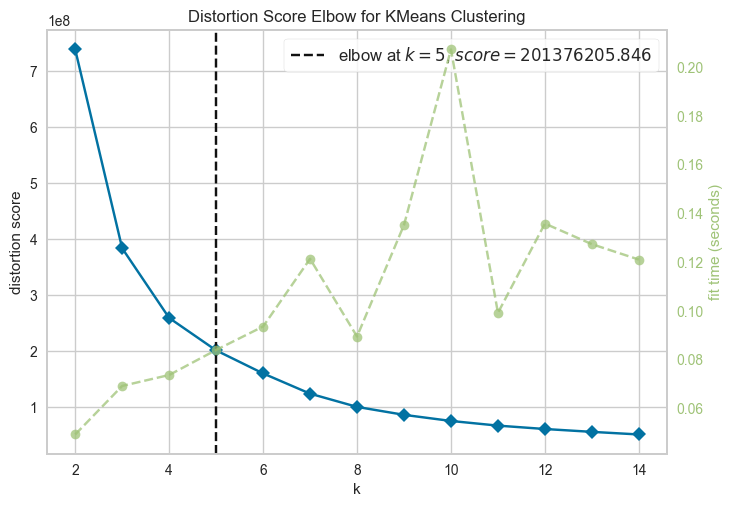

In [49]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10)

# Création du visualiseur (metric = distorsion)
visualizer = KElbowVisualizer(model, k=k_range)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Nous remarquons une inflexion de la courbe à **5 clusters**. 

### <span style='background:green; color:white'>b/ Calinski_harabasz</span>

Cette métrique de performance calcule le ratio entre la dispersion inter-cluster et la dispersion intra-cluster. Plus le score est élevé, plus les clusters sont denses et séparés.

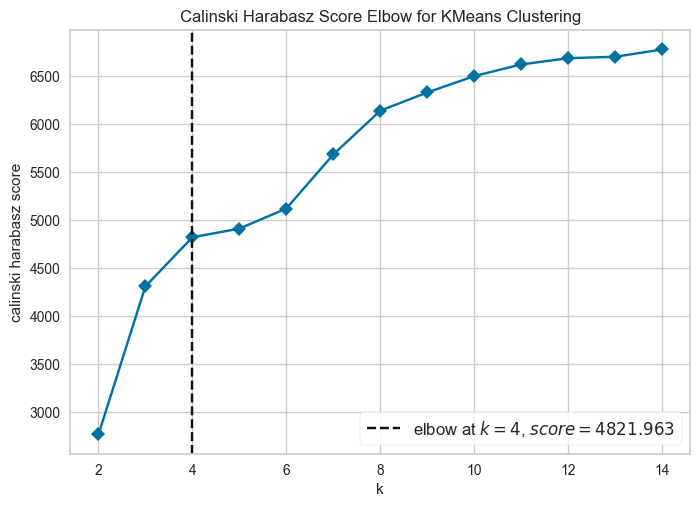

In [50]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10)

# Création du visualiseur
visualizer = KElbowVisualizer(model, k=k_range, metric="calinski_harabasz", timings=False)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Nous remarquons une inflexion de la courbe à **4 clusters**. 

### <span style='background:green; color:white'>c/ Silhouette</span>

La métrique de **silhouette** calcule la distance moyenne entre chaque point et tous les autres points du même cluster. Cette distance est ensuite comparée à la distance moyenne entre le point et tous les points d'un autre cluster. La silhouette est comprise entre -1 et 1. Plus la valeur est proche de 1, plus le point est proche des autres points de son cluster et éloigné des points des autres clusters.

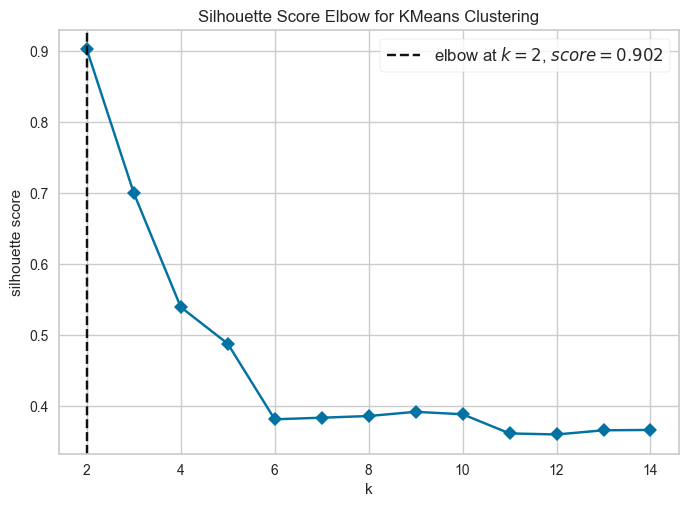

In [51]:
# Création Kmeans (avec 10 initialisations différentes)
model = KMeans(n_init=10)

# Création du visualiseur
visualizer = KElbowVisualizer(model, k=k_range, metric="silhouette", timings=False)

# Fit le modèle sur les données
visualizer.fit(X)

# Afficher le graphique
visualizer.poof()
plt.show()

Cette métrique ne retient que la valeur la plus haute soit **2 clusters**. 

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Notre intuition se tourne plutôt sur la métrique de distorsion qui permet d'avoir une segmentation convenable avec un clustering de 5 clusters. </div> 

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>


### <span style='background:green; color:white'>a/ Visualisation de la silhouette</span>

Nous utilisons le visualisateur de silhouette pour visualiser les 5 clusters. 

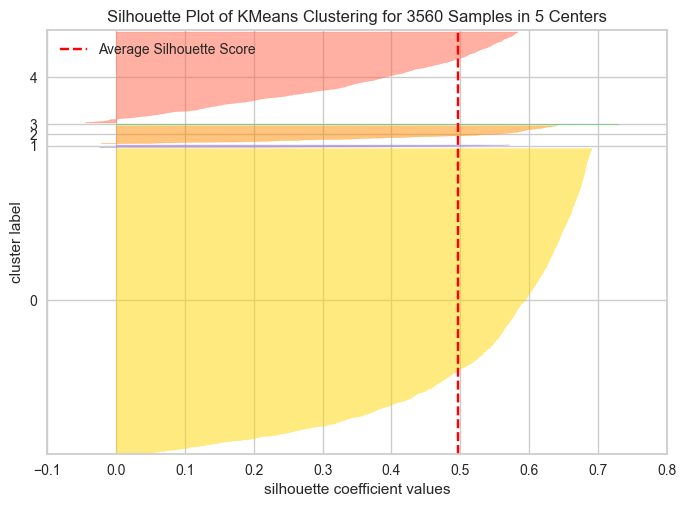

Cluster 4: 778 observations
Cluster 3: 4 observations
Cluster 2: 154 observations
Cluster 1: 22 observations
Cluster 0: 2602 observations


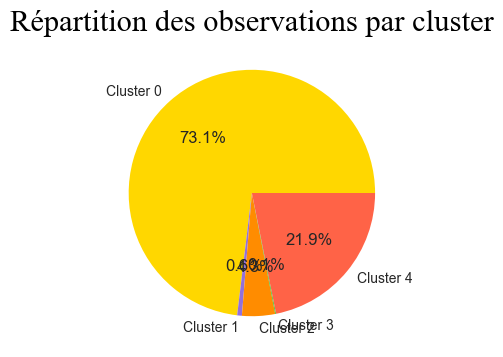

In [192]:
# Création Kmeans (avec 10 initialisations différentes)
model_selected = KMeans(5, n_init=10)

# Création du visualiseur
visualizer_selected = SilhouetteVisualizer(model_selected, colors=colors_list)

# Fit le modèle sur les données
visualizer_selected.fit(X)

# Afficher le graphique
visualizer_selected.poof()
plt.show()

# Obtenir les labels de cluster pour chaque observation
labels = visualizer_selected.labels_

# Compter le nombre d'observations dans chaque cluster
counts = np.bincount(labels)

# Afficher le nombre d'observations dans chaque cluster
for i, count in reversed(list(enumerate(counts))):
    print(f"Cluster {i}: {count} observations")

# Créer un diagramme à secteurs pour visualiser la répartition des observations
plt.figure(figsize=(8, 4))
plt.pie(counts, labels=[f'Cluster {i}' for i in range(len(counts))], autopct='%1.1f%%', colors=colors_list)
plt.title('Répartition des observations par cluster', fontdict=font_title)
plt.show()

A faire...


### <span style='background:green; color:white'>b/ Score de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec le score de Davies-Bouldin. 

Ce score est la moyenne des coefficients de similarité entre chaque cluster. Plus le score est faible, plus les clusters sont denses et séparés.

In [193]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X, model_selected.labels_)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 0.64


Un score de Davies-Bouldin proche de 0 indique un bon clustering.

### <span style='background:green; color:white'>c/ Moyenne par cluster</span>

Nous concatenons les données avec les labels de cluster.

In [194]:
# Dataframe avec la feature des clusters
df_rfm_cluster = pd.concat([X, pd.Series(model_selected.labels_, index=X.index, name='Cluster')], axis=1)

# Affichage
display(df_rfm_cluster.head(3))

,recence,frequence,montant,Cluster
customer_unique_id,,,,
000fbf0473c10fc1ab6f8d2d286ce20c,33,4,362.36,0
0058f300f57d7b93c477a131a59b36c3,159,3,271.60,0
0064a1b5f5cddd047c987b988a90c8c1,180,4,269.20,0


Nous affichons la moyenne des clusters pour chaque feature afin de vérifier la pertinence du clustering.

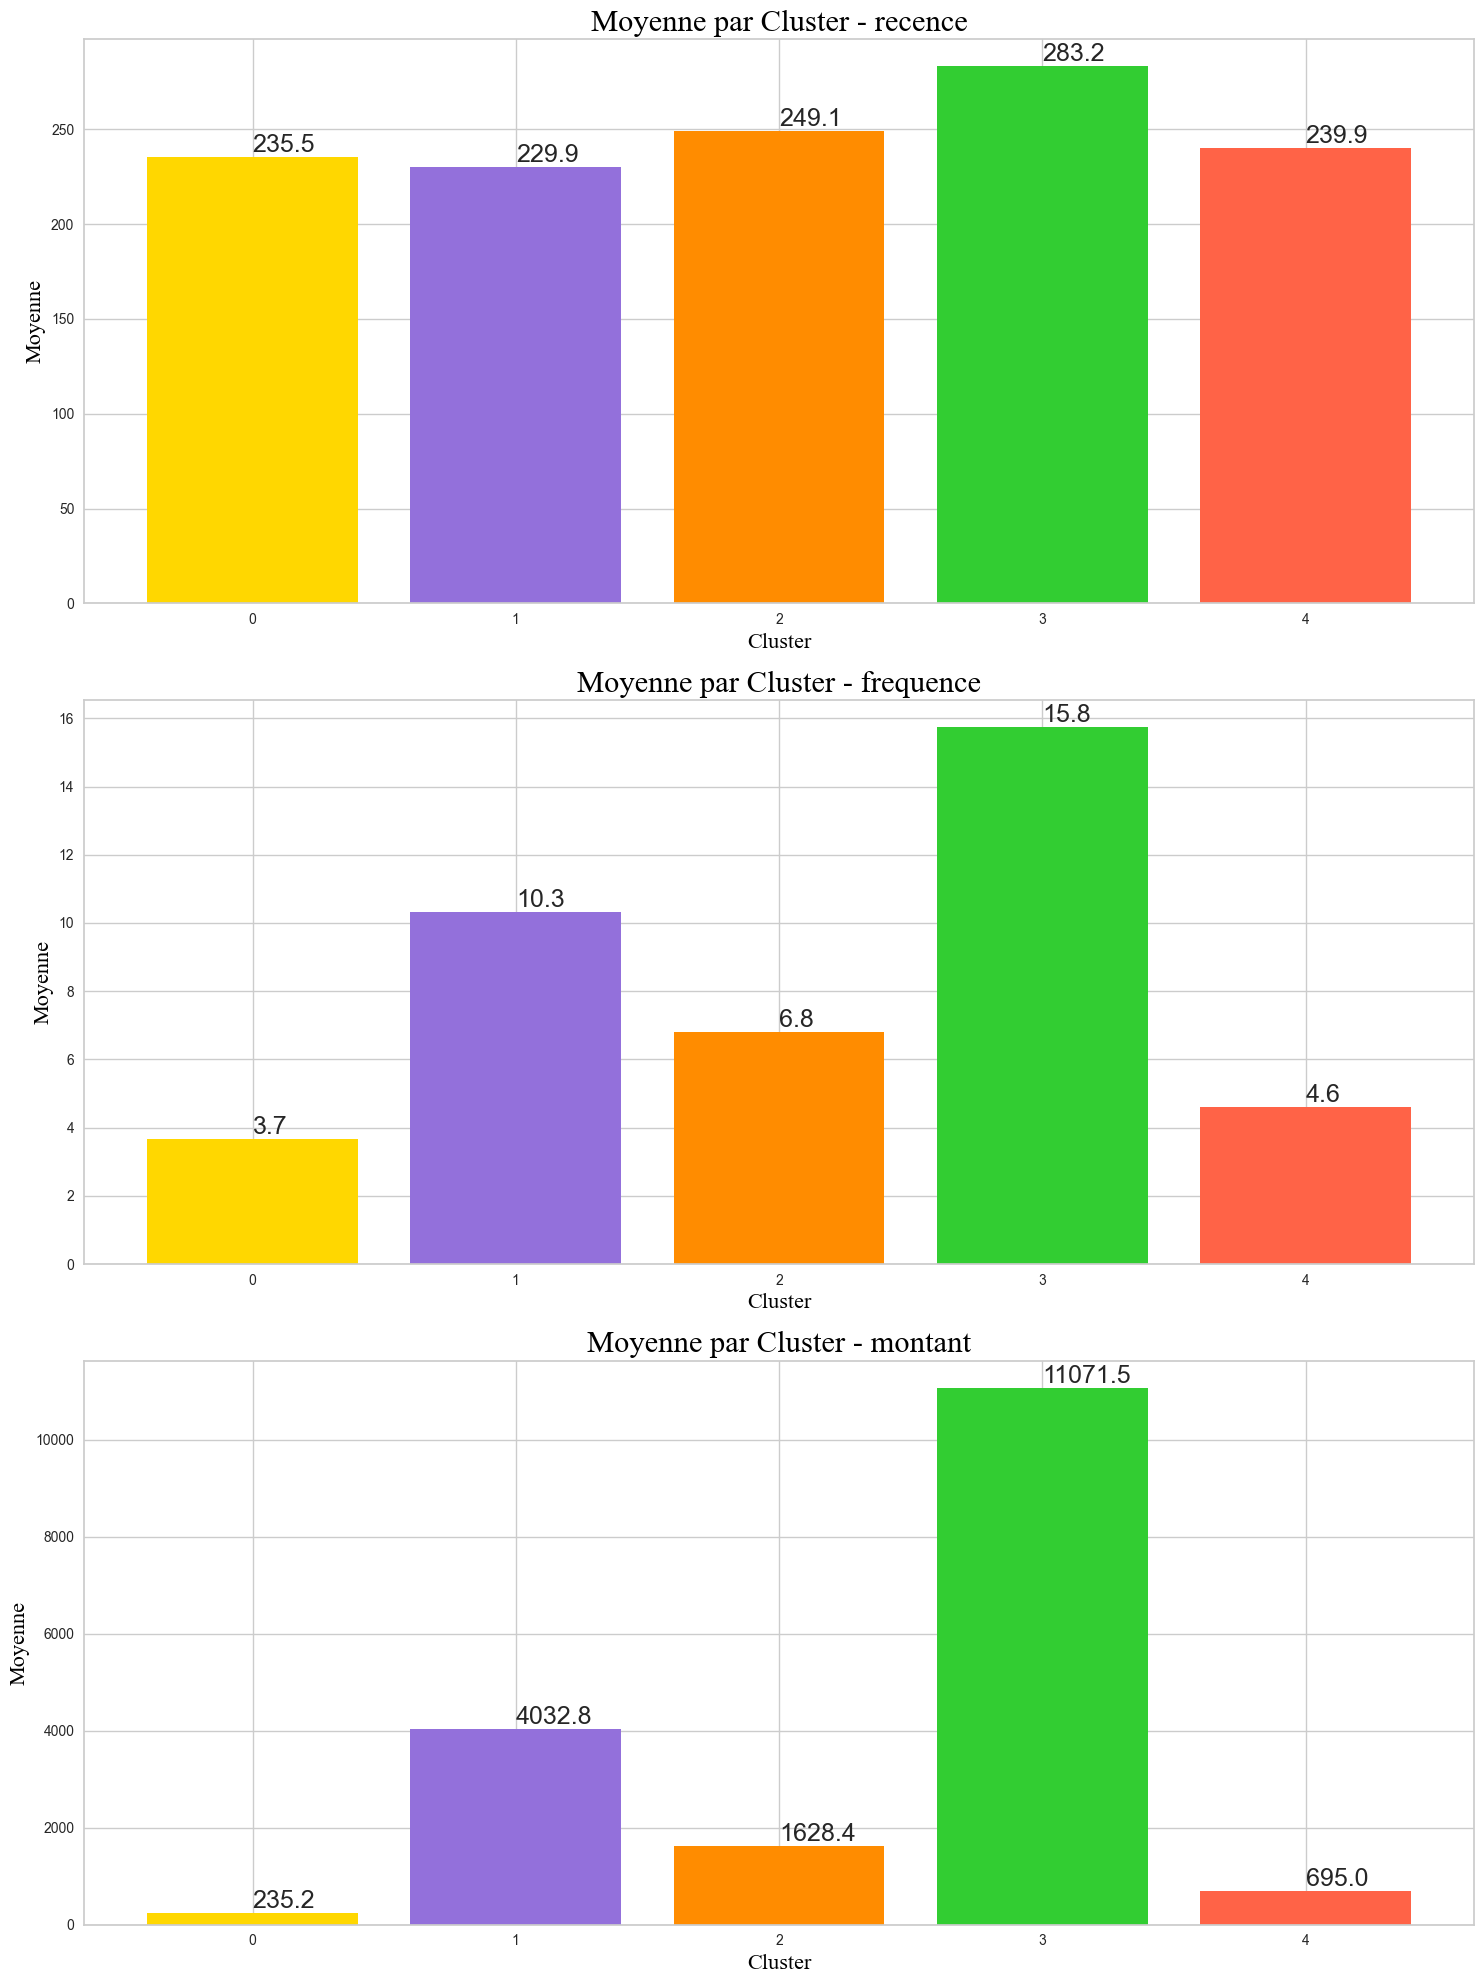

In [195]:
# Calculer la moyenne pour chaque feature par cluster
moyenne_par_cluster = df_rfm_cluster.groupby('Cluster').mean()

# Créer des sous-graphiques
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

# Tracer la moyenne par cluster pour chaque caractéristique
for i, caractéristique in enumerate(moyenne_par_cluster.columns):
    ax = axes[i]
    bars = ax.bar(moyenne_par_cluster.index, moyenne_par_cluster[caractéristique], color=colors_list)
    ax.set_xlabel('Cluster', fontdict=font_axe)
    ax.set_ylabel('Moyenne', fontdict=font_axe)
    ax.set_title(f'Moyenne par Cluster - {caractéristique}', fontdict=font_title)
    
    # Ajouter des étiquettes de données
    for bar in bars:
        hauteur = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, hauteur, round(hauteur, 1), va='bottom', fontsize=18)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()

# Afficher le graphique
plt.show()

a faire...

### <span style='background:green; color:white'>d/ Radar par cluster</span>

Nous normalisons les moyennes pour pouvoir les comparer entre les clusters. 

In [196]:
# Créer un scaler
scaler = MinMaxScaler()

# Ajuster et transformer les données
moyenne_par_cluster_scaled = scaler.fit_transform(moyenne_par_cluster)

# Convertir le résultat en DataFrame
moyenne_par_cluster_scaled = pd.DataFrame(moyenne_par_cluster_scaled, columns=moyenne_par_cluster.columns)

# Affichage
display(moyenne_par_cluster_scaled)

,recence,frequence,montant
0,0.10566,0.00000,0.00000
1,0.00000,0.55077,0.35045
2,0.36113,0.26076,0.12857
3,1.00000,1.00000,1.00000
4,0.18736,0.07798,0.04243


Nous affichons un radar pour chaque cluster.

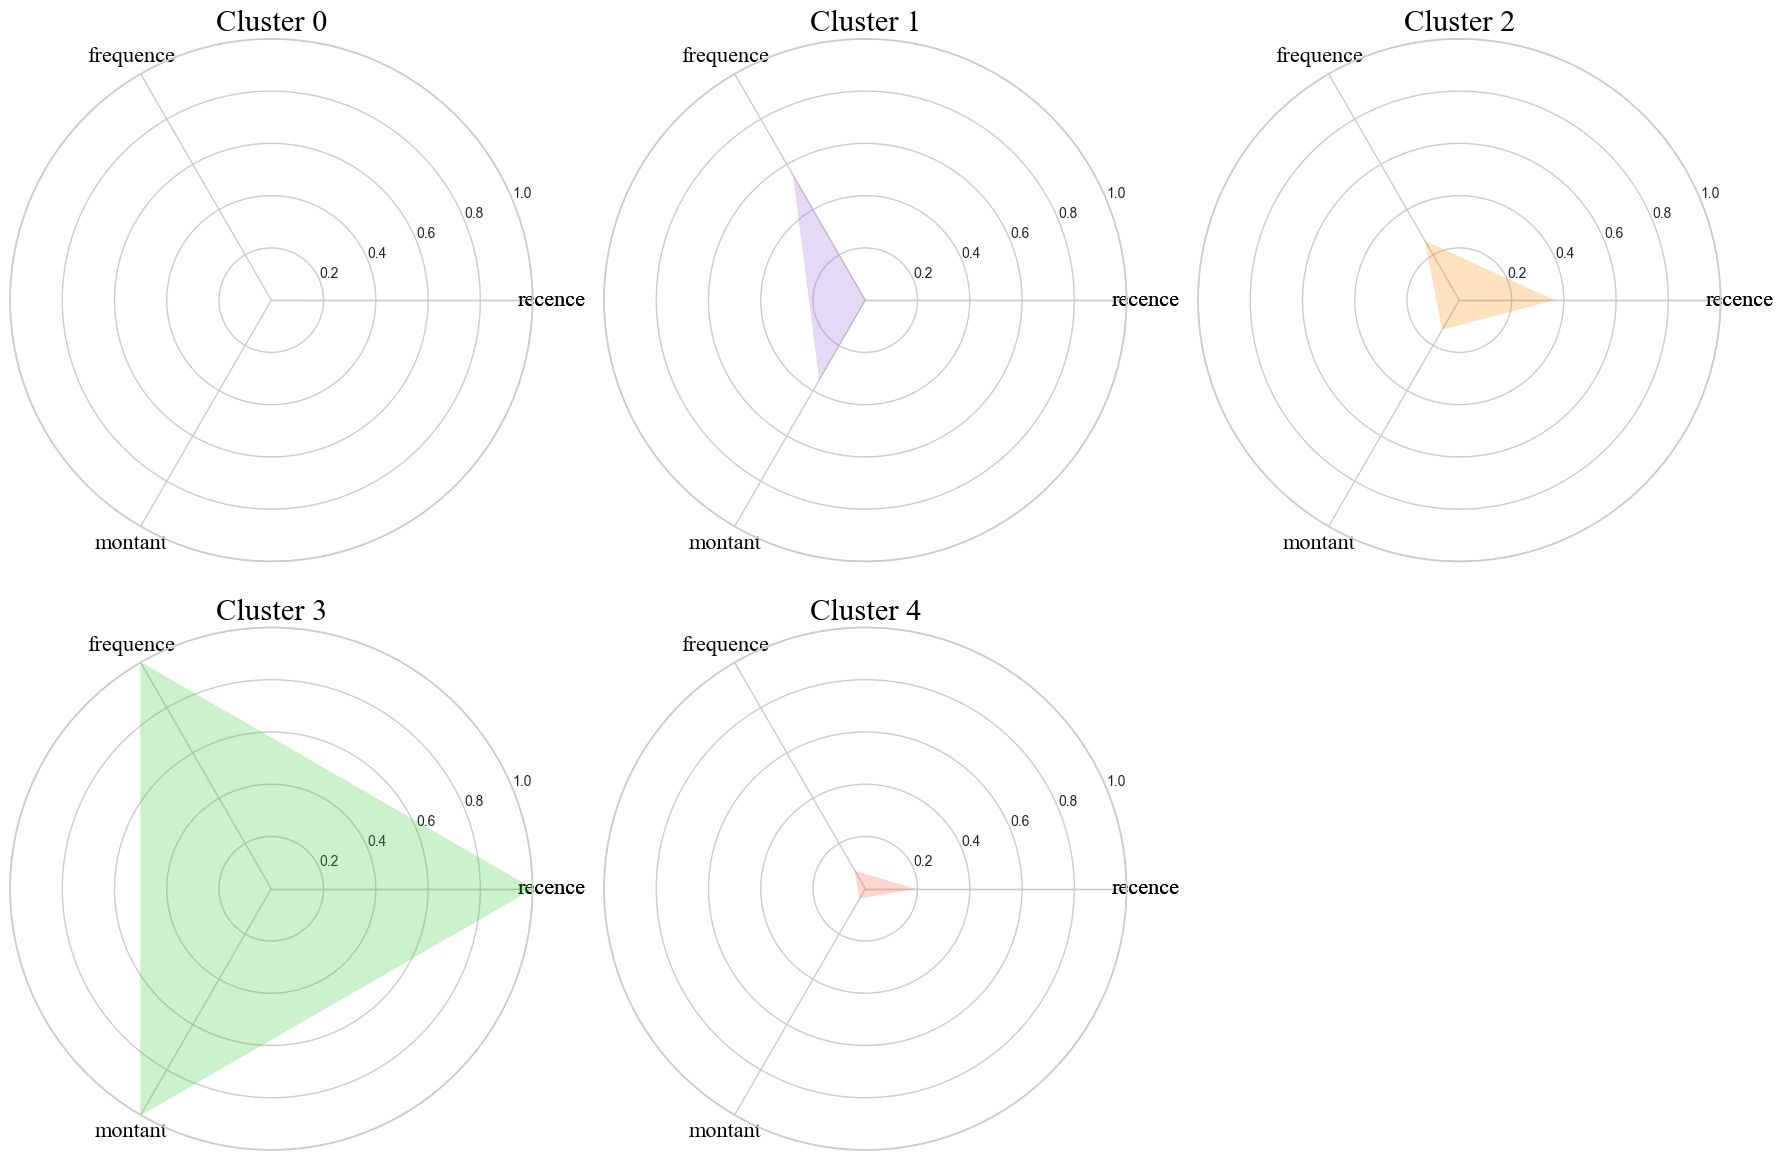

In [197]:
# Nombre de clusters et features
num_clusters = moyenne_par_cluster_scaled.shape[0]
num_vars = moyenne_par_cluster_scaled.shape[1]

# Calculer l'angle de chaque axe (+ répeter le premier angle)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Créer une figure avec 3 subplots par ligne
num_rows = math.ceil(num_clusters / 3)
fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows), subplot_kw=dict(polar=True))

# Aplatir la liste d'axes
axs = axs.flatten()

# Pour chaque cluster
for i, row in moyenne_par_cluster_scaled.iterrows():

    # Sélection du subplot du cluster
    ax = axs[i]
    
    # création du graphique radar
    values = row.values.flatten().tolist()
    values += values[:1] 
    ax.fill(angles, values, color=colors_list[i], alpha=0.25,)
    
    # Etiquettes de l'axe x avec les features
    labels = list(moyenne_par_cluster_scaled.columns)
    labels += labels[:1]
    ax.set_xticks(angles)
    ax.set_xticklabels(labels, fontdict=font_axe)

    # Fixer les limites de l'axe y
    ax.set_ylim(0, 1)
    
    # Titre du subplot
    ax.set_title(f'Cluster {i}', fontdict=font_title)

# Supprimer les subplots inutilisés
for i in range(num_clusters, num_rows * 3):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

a faire ...

### <span style='background:green; color:white'>d/ Coefficient de Gini</span>

avec le coeffcient de GINI :
https://towardsdatascience.com/clustering-for-data-nerds-ebbfb7ed4090


<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Ici </div> 

# <span style='background:blue'>Etape 2 : K-mean clustering RFM + Satisfaction</span>